In [6]:
%pylab inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [149]:
# Make tunnel to database server
#!ssh -f -L27017:ecosensedb02.cs.au.dk:27017 -N eco-admin@ecosensedb03.cs.au.dk
# Access with mongo client
# mongo ecosense -u process -p ge6acuRa
# Remember to call rs.slaveOk()
import attr
import json
import IPython
import json
from ipyleaflet import GeoJSON,Map,CircleMarker,Circle,Marker,Polyline,Rectangle

In [150]:
data_dir ='/Users/alehmann/Documents/Documents/HIH/phd_application/papers/IMWUT2017/data/'

In [151]:
@attr.s
class City(object):
    json = attr.ib(default=None)
    rect = attr.ib(default=None)
    center = attr.ib(default=None)

herning = City()
herning.json = '/Volumes/TOSHIBA EXT/HCYRE001_Herning_1000.json'
herning.rect = Rectangle(bounds=[(56.097,8.86),(56.1632,9.016)],fill=False,weight=1)
herning.center = [56.089312,8.992626]
herning.zoom = 10
herning.pg = '/Volumes/TOSHIBA EXT/inserts_herning.pg'
aarhus = City()
aarhus.json = '/Volumes/TOSHIBA EXT/HCYRE001_aarhus_1000.json'
aarhus.rect = Rectangle(bounds=[(56.089312,9.992626),(56.245453,10.281049)],fill=False,weight=1)
aarhus.center = [56.189312,9.79942626953125]
aarhus.zoom = 10
aarhus.pg = '/Volumes/TOSHIBA EXT/inserts_aarhus.pg'


city = herning

In [152]:
from math import atan2,sin,cos,sqrt,pi
def rad(angle):
    return angle/180*pi

def haversine(*args):
    # a = sin²(Δφ/2) + cos(φ1).cos(φ2).sin²(Δλ/2)
    # c = 2.atan2(√a, √(1−a))
    # d = R.c
    # d er i kilometer?
    R = 6371 #km
    
    lat, lon, lat1, lon1 = map(rad, args)
    dlat = lat1 - lat
    dlon = lon1 - lon
    a = sin(dlat/2)**2 + cos(lat)*cos(lat1)*sin(dlon/2)**2
    c = 2*atan2(sqrt(a),sqrt(1-a))
    d = R*c
    return d

In [153]:
@attr.s
class Location(object):
    time = attr.ib()
    latitude = attr.ib()
    longitude = attr.ib()
    speed = attr.ib()    

insert_string = "INSERT INTO {name} {args} VALUES".format(name='locations',args=(1,2,3))

def convert_json(large_json_file,write_pg_script=True):
    res = {}
    old_lat = old_long = 0
    out = open(city.pg,'w')
    with open(large_json_file) as f:
        for line in f:
            temp = json.loads(line)
            client = temp['clientInstallId']
            oid = temp['_id']['$oid']
            gps = res.setdefault(client,[])
            tpos = temp['gpsLocations']
            for x in tpos:
                if old_lat == x['latitude'] and old_long == x['longitude']:
                    continue #print '.',
                else:
                    if write_pg_script:
                        values_string = "'{}','{}',".format(client,oid)+ ','.join([str(x[y]) for y in keys])    
                        insert_string = "INSERT INTO {name} ({args}) VALUES ({val});\n".\
                            format(name='locations',args=key_string,val=values_string)
                        out.write(insert_string)

                    old_lat = x['latitude']
                    old_long = x['longitude']
                    gps.append(Location(x['timestamp'],x['latitude'],x['longitude'],x['speed']))
            #gps.append([Location(x['timestamp'],x['latitude'],x['longitude'],x['speed']) for x in tpos])
    out.close()        #print temp['clientInstallId'],len(tpos), len(res.keys())
    return res


%time res = convert_json(city.json,write_pg_script=False)
Immaculate_cpoy = res.copy()

IOError: [Errno 2] No such file or directory: '/Volumes/TOSHIBA EXT/inserts_herning.pg'

In [6]:
create_string = """CREATE TABLE locations (id serial,client TEXT, oid TEXT, bearing INTEGER,hasBearing BOOLEAN ,timestamp BIGINT,
                altitude float,longitude float,hasAltitude BOOLEAN, hasNumberOfSatellites BOOLEAN,
                hasAccuracy BOOLEAN,hasSpeed BOOLEAN,latitude float,numberOfSatellites INTEGER,speed float, 
                accuracy INTEGER);"""

with open(city.json) as f:
    line = f.readline()
    temp = json.loads(line)
    #gps = res.setdefault(temp['clientInstallId'],[])
    client = temp['clientInstallId']
    oid = temp['_id']['$oid']
    print oid
    tpos = temp['gpsLocations']
    keys = tpos[0].keys()
    key_string = ','.join(keys)
    
key_string = 'client,oid,'+key_string
values_string = "'{}','{}',".format(client,oid)+','.join([str(tpos[0][x]) for x in keys])    

print values_string
insert_string = "INSERT INTO {name} ({args}) VALUES ({val})".format(name='locations',args=key_string,val=values_string)
print insert_string




IOError: [Errno 2] No such file or directory: '/Volumes/TOSHIBA EXT/HCYRE001_Herning_1000.json'

In [4]:
len([150366,184191,153154,133818,139785,168750,140072,105596,
                    106502,92807,145523,150620,179051,168838,145671,168316,
                    109629,131690,123779,104118,98501,116817,117349,130963,
                    91088,89980,97516,38105,36387,2732,57144,67059,1663,
                    22522,2726,32969,49237,520,65307,11637,10318,191871,
                    15355,68852,23446,199913])

46

In [ ]:
#Order data by client and timestamp. Find gaps larger than 5 minutes
Order_and_gaps ="""
create table trips_start_end as
with ordered as (
	select *, ROW_NUMBER() over (partition by Client order by timestamp ASC) as rn
	from locations 
)
 select o1.client,o1.id as id1, o2.id as id2, to_timestamp(o1.timestamp/1000) as t1, to_timestamp(o2.timestamp/1000) as t2, 
o2.timestamp-o1.timestamp as diff from
ordered o1 inner join ordered o2 on o1.rn+1 = o2.rn and o1.client=o2.client
where o2.timestamp-o1.timestamp > 5*60*1000;
"""
Insert_first_trip = """insert into trips_start_end (client,id1,id2,t1) (
with ordered as (
	select *, ROW_NUMBER() over (partition by Client order by timestamp ASC) as rn
	from locations 
)
 select client,0 as id1, id as id2, to_timestamp(timestamp/1000) as t1 
from
ordered 
where rn=1);"""

#put start end in same row
trips = """
create table trips_start_end_for_real as
with ordered as (
	select *, ROW_NUMBER() over (partition by Client order by t1 ASC) as rn
	from trips_start_end 
)
select o1.client,o1.id2 as start, o2.id1 as end,o2.t1,o1.rn 
from ordered o1 join ordered o2 on o1.client=o2.client and o1.rn+1=o2.rn"""
#Create the trips locations
trips_loc = """create table trips_locations as
select tr.rn,l.* from locations l join trips_start_end_for_real tr on l.client = tr.client where
 l.id>=tr.start and l.id<=tr.end"""

Count_trips_pr_DOW = """select count(*),date_part('dow',t1) as day from trips_start_end group by day order by day""",
Count_trips_pr_time_of_day_workdays = """select count(*),date_part('hour',t1) as day from trips_start_end where 0<date_part('dow',t1)
and date_part('dow',t1)<6 group by day order by day"""

Count_trips_pr_time_of_day_workdays_minutes = """select count(*),date_part('hour',t1)*60+floor(date_part('minute',t1)/30)*30 as day from trips_start_end 
where 0<date_part('dow',t1) and date_part('dow',t1)<6 group by day order by day"""

Find_trip_start_end = """create table temp_start_end as select row_number() over (partition by client order by id2) as rn, 
          client, id2 as start, lead(id1) over () as end 
from trips_start_end order by client,id2"""
Find_trip_locations = """create table test_trips as select l.client,se.rn, l.locs, l.speed from locations l join temp_start_end se on
          l.client = se.client where se.start < l.id and l.id < se.end""",

walk_run_bike = """drop table walk_run; create table walk_run as select rn,client from (select max(speed) as maxi,rn,client
from trips_locations group by rn,client) as q where maxi<25/3.6"""
walk_loc = """create table walk_loc as select tr.* from trips_locations tr join walk_run w 
on w.client=tr.client and w.rn=tr.rn"""
delete_walk = """delete from trips_locations where id in (select id from walk_loc)"""
flight = """create table flights as select rn,client from (select client,max(speed) as maxi,max(altitude) as maxh,rn
from trips_locations group by rn,client) as q where
maxi>150/3.6 and maxh > 310"""
flight_loc= """create table flight_loc
as select tr.* from trips_locations tr join flights f on f.client=tr.client and f.rn=tr.rn"""
delete_flight = """delete from trips_locations where id in (select id from flight_loc)"""
bicycle = """create table bicycle as select rn from (select max(speed) as maxi,rn from
test_trips2 group by rn) as q where maxi<25/3.6"""

route_id ="""update trips_locations set route_id = client||to_char(rn,'99999') """

Create_grid = """create table grids as select cell from ( Select (ST_DUMP(makegrid_2d(ST_SetSRID(
   ST_MakeBox2D(ST_Point(8.77,56.0),ST_Point(9.16,56.2))
,4326),1000,4093))).geom as cell) as grid"""]
grid_speed = """create table grid_speed as select avg(speed),max(speed), cell from test_trips2 join grid1000 on 
	ST_CONTAINS(cell,locs) group by cell"""
# Query til at finde huller i data - antager at det betyder en afsluttet rejse 'trip'
# 112 trips i Aarhus
# 2179 trips i Herning
twoway_2_oneway1 = """insert into twoway (id,osm_id,osm_name,osm_source_id,osm_target_id,clazz,flags,source,target,km,kmh,cost,reverse_cost,x1,y1,x2,y2,geom_way) 
select id+1000000,osm_id,osm_name,osm_source_id,osm_target_id,clazz,flags,target,source,km,kmh,reverse_cost,cost,x1,y1,x2,y2,geom_way from twoway"""
get_roads_from trips="""create table roads_used2 as SELECT rn, nn(locs,0.00001,2,100,'her_2po_4pgr','id','geom_way')
            FROM trips group by rn,nn;"""
map_matching="""create table roads_used_noidle_2 as SELECT rn, nn(locs,0.00001,2,100,'her_2po_4pgr_oneways','id','geom_way')
            FROM trips_locations where speed > 1  group by rn,nn;"""
add_roadused_geom_way="""alter table roads_used_noidle_2 add column geom_way geometry;
update roads_used_noidle_2 set geom_way = her.geom_way from her_2po_4pgr_oneways her where nn=her.id"""
source_connected ="""create table connected as
(with dummy as
(select route_id,nn,source,target from roads_used_noidle_2 group by route_id,nn,source,target 
order by route_id)
select sourc_con.route_id,sourc_con.nn1 as interior_way,sourc_con.nn as source_connected,d3.nn as target_connected from dummy d3 join
(select d1.route_id,d1.nn as nn1,d2.nn,d1.source,d1.target as t1,d2.source,d2.target
from dummy d1 join dummy d2 on d1.route_id=d2.route_id  and d1.nn<> d2.nn 
where d1.source=d2.target or d1.source=d2.source) as sourc_con on 
sourc_con.route_id=d3.route_id and sourc_con.nn1<>d3.nn 
where sourc_con.t1=d3.source or sourc_con.t1=d3.target) """
target_connected = """create table connected_t as
(with dummy as
(select route_id,nn,source,target from roads_used_noidle_2 group by route_id,nn,source,target 
order by route_id)
select sourc_con.route_id,sourc_con.nn1 as interior_way,sourc_con.nn as source_connected,d3.nn as target_connected from dummy d3 join
(select d1.route_id,d1.nn as nn1,d2.nn,d1.source as s1,d1.target as t1,d2.source,d2.target
from dummy d1 join dummy d2 on d1.route_id=d2.route_id  and d1.nn<> d2.nn 
where d1.target=d2.target or d1.target=d2.source) as sourc_con on 
sourc_con.route_id=d3.route_id and sourc_con.nn1<>d3.nn 
where sourc_con.s1=d3.source or sourc_con.s1=d3.target) """
target_connected_source_and_target="""drop table connected_t ;create table connected_t as
(with dummy as
(select route_id,nn,source,target from roads_used_noidle_2 group by route_id,nn,source,target 
order by route_id)
select sourc_con.route_id,sourc_con.source,sourc_con.target,sourc_con.nn1 as interior_way,sourc_con.nn as source_connected,d3.nn as target_connected 
from dummy d3 join
(select d1.route_id,d1.nn as nn1,d2.nn,d1.source as s1,d1.target as t1,d2.source,d2.target
from dummy d1 join dummy d2 on d1.route_id=d2.route_id  and d1.nn<> d2.nn 
where d1.target=d2.target or d1.target=d2.source) as sourc_con on 
sourc_con.route_id=d3.route_id and sourc_con.nn1<>d3.nn 
where sourc_con.s1=d3.source or sourc_con.s1=d3.target) """
interior_way="""create table interior_way as select route_id,geom_way from (select s.route_id,s.interior_way from connected s join connected_t t on s.route_id=t.route_id and s.interior_way=t.interior_way 
group by s.route_id,s.interior_way) as f join her_2po_4pgr_oneways her on her.id=f.interior_way"""

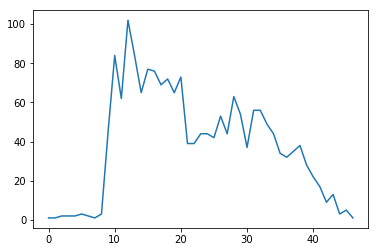

In [31]:
trips_workdays0="""2;0
4;1
2;2
5;3
4;4
129;5
164;6
149;7
153;8
141;9
138;10
78;11
88;12
95;13
107;14
91;15
112;16
93;17
66;18
73;19
50;20
26;21
16;22
6;23""".split('\n')

trips_workdays30="""1;0
1;30
2;60
2;90
2;120
3;180
2;210
1;240
3;270
45;300
84;330
62;360
102;390
84;420
65;450
77;480
76;510
69;540
72;570
65;600
73;630
39;660
39;690
44;720
44;750
42;780
53;810
44;840
63;870
54;900
37;930
56;960
56;990
49;1020
44;1050
34;1080
32;1110
35;1140
38;1170
28;1200
22;1230
17;1260
9;1290
13;1320
3;1350
5;1380
1;1410""".split('\n')
trips_workdays = [x.split(';')[::-1] for x in trips_workdays30]

trips_workdays = [(float(x[1])) for x in trips_workdays]
trips_workdays = array(trips_workdays)
plot(trips_workdays)

In [1]:
import psycopg2

In [3]:
conn = psycopg2.connect(host='localhost',dbname='Ecosense_herning',user='postgres')

30 2



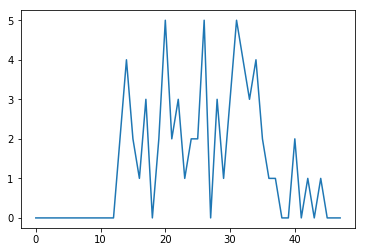

In [138]:
query = """select count(*),date_part('hour',t1)*60+floor(date_part('minute',t1)/{0})*{0} as day from trips_start_end 
where 0<date_part('dow',t1) and date_part('dow',t1)<6 group by day order by day"""
import math
resolution = 30
app = 60/resolution if 60%resolution==0 else 60/resolution+1
print resolution,app
points = []
for i in range(24):
    for j in range(app):
        points.append(j*resolution+i*60)
cursor = conn.cursor()
cursor.execute(query.format(resolution))
res = []
res_ = cursor.fetchall()
print 
for i in points:
    
    if res_ and res_[0][1] == i:
        res.append(res_.pop(0))
    else:
        res.append((0,i))
plot([x[0] for x in res])

In [139]:
speed_accuracy = 2
query = """select count(*),floor(speed/{0})*{0} as speed_bucket from locations where speed > 0 
        group by speed_bucket order by speed_bucket"""

cursor = conn.cursor()
cursor.execute(query.format(speed_accuracy))

res_ = cursor.fetchall()

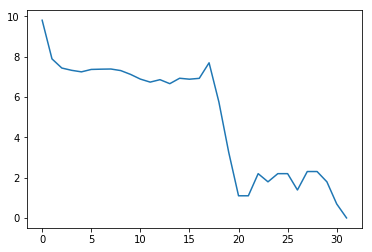

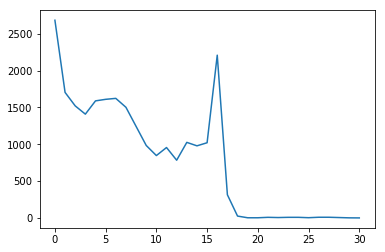

In [145]:
from math import log
plot([log(x[0]) for x in res_[0:]])
figure()
plot([(x[0]) for x in res_[1:]])


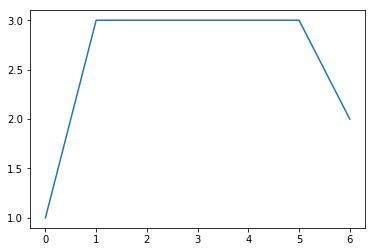

In [136]:
dow="""169;0
331;1
378;2
386;3
350;4
347;5
218;6""".split('\n')
plot([x[0] for x in dow])

In [148]:

#Check of the order of the merged data, and measure the gaps in time
res = 
for u in res:
    user = res[u]
    for i,t in enumerate(user[:-1]):
                
        if t[-1].time > user[i+1][0].time:
            j=i-1
            while j>=0 and (user[j][-1].time-user[i+1][0].time)>0:
                j -= 1
            user.insert(j,user.pop(i+1))
            print "wrong order", u,i,j
        else:
            print user[i+1][0].time - t[-1].time
    res[u] = user    #42dd6894-46f5-4c25-afec-ea3dc863d0e1 45 44

TypeError: list indices must be integers, not tuple

In [147]:
dist = []
outliers = []
new_traces = {}
for u in res:
    for i,t in enumerate(res[u]):
        for j,x in enumerate(t[:-1]):
            delta = haversine(x.latitude,x.longitude,t[j+1].latitude,t[j+1].longitude)
            dist.append(delta)
            if delta > 1:
                outliers.append(x)
                new_traces.setdefault(u,[])
                new_traces[u].append([i,j])
                print u,i,j,len(t),delta,t[j+1].time-x.time,x.latitude,x.longitude,t[j+1].latitude,t[j+1].longitude
cres = res.copy()
for u in cres:
    if u in new_traces:
        templist = [] 
        old = 0
        for i,j in new_traces[u]:
            for x in range(old,i):
                templist.append(cres[u][x])
            temp = cres[u][i]
            head = temp[:j+1]
            tail = temp[j+1:]
            templist.append(head)
            templist.append(tail)
            old = i+1
            if not head:
                print "=============>",u,i,j,len(temp)
            if  not tail:
                print "=============0>",u,i,j,len(temp)
        if old < len(cres[u]):
            for x in range(old,len(cres[u])):
                templist.append(cres[u][x])
        cres[u] = templist

TypeError: list indices must be integers, not tuple

In [8]:
#Create trips by merging datasets less than 60 seconds apart 
res = cres.copy()
trips ={}

for u in res:
    user = res[u]            
    temp_trip = user[0]
    trips[u] = []
    for i,t in enumerate(user[:-1]): 
        print u,i
        if user[i+1][0].time-t[-1].time <60000:
            temp_trip.extend(user[i+1])
        else:
            trips[u].append(temp_trip)
            temp_trip = user[i+1]
    trips[u].append(temp_trip)

762ea076-ed08-4e42-8549-678cf641eb47 0
762ea076-ed08-4e42-8549-678cf641eb47 1
762ea076-ed08-4e42-8549-678cf641eb47 2
762ea076-ed08-4e42-8549-678cf641eb47 3
762ea076-ed08-4e42-8549-678cf641eb47 4
762ea076-ed08-4e42-8549-678cf641eb47 5
762ea076-ed08-4e42-8549-678cf641eb47 6
762ea076-ed08-4e42-8549-678cf641eb47 7
762ea076-ed08-4e42-8549-678cf641eb47 8
762ea076-ed08-4e42-8549-678cf641eb47 9
762ea076-ed08-4e42-8549-678cf641eb47 10
762ea076-ed08-4e42-8549-678cf641eb47 11
762ea076-ed08-4e42-8549-678cf641eb47 12
762ea076-ed08-4e42-8549-678cf641eb47 13
762ea076-ed08-4e42-8549-678cf641eb47 14
762ea076-ed08-4e42-8549-678cf641eb47 15
762ea076-ed08-4e42-8549-678cf641eb47 16
762ea076-ed08-4e42-8549-678cf641eb47 17
762ea076-ed08-4e42-8549-678cf641eb47 18
762ea076-ed08-4e42-8549-678cf641eb47 19
762ea076-ed08-4e42-8549-678cf641eb47 20
762ea076-ed08-4e42-8549-678cf641eb47 21
762ea076-ed08-4e42-8549-678cf641eb47 22
762ea076-ed08-4e42-8549-678cf641eb47 23
762ea076-ed08-4e42-8549-678cf641eb47 24
762ea076-e

In [9]:
cres['762ea076-ed08-4e42-8549-678cf641eb47'][53]

[Location(time=1436042341208, latitude=56.2340348, longitude=10.26748646, speed=27.5),
 Location(time=1436042341209, latitude=56.2340348, longitude=10.26748646, speed=27.5),
 Location(time=1436042341210, latitude=56.2340348, longitude=10.26748646, speed=27.5),
 Location(time=1436042341211, latitude=56.2340348, longitude=10.26748646, speed=27.5),
 Location(time=1436042341212, latitude=56.2340348, longitude=10.26748646, speed=27.5),
 Location(time=1436042341213, latitude=56.2340348, longitude=10.26748646, speed=27.5),
 Location(time=1436042341214, latitude=56.2340348, longitude=10.26748646, speed=27.5),
 Location(time=1436042341215, latitude=56.2340348, longitude=10.26748646, speed=27.5),
 Location(time=1436042341216, latitude=56.2340348, longitude=10.26748646, speed=27.5),
 Location(time=1436042341216, latitude=56.2340348, longitude=10.26748646, speed=27.5),
 Location(time=1436042341217, latitude=56.2340348, longitude=10.26748646, speed=27.5),
 Location(time=1436042341218, latitude=56.2

In [10]:
len_trip = [len(res[u]) for u in res]
print sum(len_trip),len_trip
len_trip = [len(trips[u]) for u in trips]
print sum(len_trip),len_trip

1121 [65, 78, 65, 413, 111, 98, 289, 2]
230 [27, 7, 4, 98, 22, 18, 52, 2]


In [11]:
dist.sort()

In [12]:
dist[-50:]

[1.0790854692460918,
 1.0892159178453678,
 1.0903929466937137,
 1.0935474198936528,
 1.095498815113749,
 1.0959620776749979,
 1.0993364291780132,
 1.106251638853256,
 1.110022245512906,
 1.1204252500297904,
 1.1205061528892428,
 1.1237864543195804,
 1.131427546441465,
 1.1428149070193783,
 1.1440908388865643,
 1.1448208094915164,
 1.1456924592336435,
 1.1490435846157003,
 1.1821212440500852,
 1.1911596744443032,
 1.1964003105218333,
 1.1973049246184368,
 1.200167436456219,
 1.2022155755851704,
 1.2153021458496835,
 1.2234023756099788,
 1.2244805149176021,
 1.2620784852967109,
 1.269906386498687,
 1.2805142107860843,
 1.2855894430691035,
 1.2915493832262641,
 1.3017716260322683,
 1.338478138791006,
 1.3530001572704287,
 1.3594059253181952,
 1.3607729089829077,
 1.380802463213136,
 1.3919528078482277,
 1.4068884435923192,
 1.411180341372288,
 1.4167721250008691,
 1.422117495976059,
 1.452746157071629,
 1.4549364427604745,
 1.534603292847946,
 1.5485695908470716,
 1.7774209190192833,
 2.1

In [13]:
import datetime


In [14]:
origin_destination = []

for u in trips : 
    for t in trips[u]:
        origin_destination.append((t[0],t[-1]))
        print datetime.datetime.fromtimestamp(t[0].time/1000),datetime.datetime.fromtimestamp(t[-1].time/1000)

2015-04-18 11:13:46 2015-04-18 11:23:02
2015-04-18 11:34:55 2015-04-18 11:37:33
2015-04-18 11:38:40 2015-04-18 11:58:49
2015-04-18 12:04:45 2015-04-18 12:05:53
2015-04-18 14:55:12 2015-04-18 15:23:04
2015-04-18 15:24:09 2015-04-18 15:33:21
2015-04-27 08:35:56 2015-04-27 08:55:19
2015-04-27 08:56:38 2015-04-27 09:05:55
2015-04-27 09:07:11 2015-04-27 09:10:20
2015-04-27 09:11:52 2015-04-27 09:15:03
2015-04-27 09:16:41 2015-04-27 09:20:53
2015-04-27 09:21:55 2015-04-27 09:31:29
2015-04-27 09:33:01 2015-04-27 09:34:43
2015-04-27 12:18:17 2015-04-27 12:21:29
2015-04-27 14:30:48 2015-04-27 14:31:44
2015-04-27 14:33:28 2015-04-27 14:37:45
2015-04-27 14:39:22 2015-04-27 14:42:37
2015-04-27 14:48:00 2015-04-27 14:56:00
2015-04-27 14:57:58 2015-04-27 15:00:38
2015-04-27 15:06:44 2015-04-27 15:07:48
2015-04-27 15:09:19 2015-04-27 15:11:15
2015-04-27 15:12:55 2015-04-27 15:17:23
2015-04-27 15:19:53 2015-04-27 15:31:35
2015-04-27 15:34:32 2015-04-27 15:37:57
2015-04-27 15:39:28 2015-04-27 15:41:53


In [15]:
len(origin_destination)

230

In [16]:
m = Map(center=city.center, zoom=city.zoom)

In [17]:
dests = []
orgs = []
for O,D in origin_destination:

    temp = Circle(location=[D.latitude,D.longitude], radius=30, weight=2,
                  color='#00F', opacity=1.0, fill_opacity=1.0,
                  fill_color='#0F0')


    temp_ = Circle(location=[O.latitude,O.longitude], radius=30, weight=2,
                  color='#F00', opacity=1.0, fill_opacity=1.0,
                  fill_color='#0F0')
    orgs.append(temp_)
    dests.append(temp)

In [18]:
out = []
for o in outliers:
    temp = Circle(location=[o.latitude,o.longitude], radius=30, weight=2,
                  color='#F0F', opacity=1.0, fill_opacity=1.0,
                  fill_color='#0F0')
    out.append(temp)

In [19]:
def add_points(points):
    for t in points:
        m.add_layer(t)

In [21]:
add_points(orgs)

In [22]:
add_points(dests)

In [20]:
add_points(out)

In [21]:
trace = []
for u in trips:
    for t in trips[u]:
        trace.append(Polyline(locations=[(x.latitude,x.longitude) for x in t],fill=False))

In [22]:
def add_trace(trace):
    for t in trace:
        m.add_layer(t)

In [54]:
add_trace(trace)

In [24]:
m += city.rect

In [29]:
m

In [27]:
def remove_points(points):
    for p in points:
        m.remove_layer(p)


In [55]:
remove_points(trace)

In [62]:
m.center = [56.18913204458089, 9.79942626953125]

In [42]:
out[-1].visible

True

In [52]:
m.add_layer(out[-10])

In [53]:
m.remove_layer(m.layers[-1])